In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import log_loss
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn import tree
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import RandomForestClassifier
import math
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack

import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
final_data = pd.read_csv(r"U:\nlp_project\Personalized-Medicine-Redefining-Cancer-Treatment\artifacts\data\final_data.csv")

In [4]:
final_data.head(5)

,ID,Gene,Variation,Text,Class
0,1,CBL,W802*,cyclin dependent kinases cdks regulate variety...,2.0
1,2,CBL,Q249E,abstract background non small cell lung cancer...,2.0
2,3,CBL,N454D,abstract background non small cell lung cancer...,3.0
3,4,CBL,L399V,recent evidence demonstrated acquired uniparen...,4.0
4,5,CBL,V391I,oncogenic mutations monomeric casitas b lineag...,4.0


In [5]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3315 entries, 0 to 3314
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3315 non-null   int64  
 1   Gene       3315 non-null   object 
 2   Variation  3315 non-null   object 
 3   Text       3315 non-null   object 
 4   Class      3315 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 129.6+ KB


### 1. train-test-split:

In [6]:
y_true = final_data['Class']

In [7]:
final_data.Gene = final_data.Gene.str.replace('\s+', '_')
final_data.Variation = final_data.Gene.str.replace('\s+', '_')

X_train, X_test, y_train, y_test = train_test_split(final_data, y_true, random_state=42, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=45, test_size=0.20)

In [8]:
print(f"Number of datapoints in train dataset: {X_train.shape[0]}")
print(f"Number of datapoints in test dataset: {X_test.shape[0]}")
print(f"Number of datapoints in validation dataset: {X_val.shape[0]}")

Number of datapoints in train dataset: 2121
Number of datapoints in test dataset: 663
Number of datapoints in validation dataset: 531


### 2. Distribution of class in train, test and split:

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
train_class_distibution = y_train.value_counts()
test_class_distribution = y_test.value_counts()
validation_class_distribution = y_val.value_counts()

Text(0.5, 1.0, 'train_class_distibution')

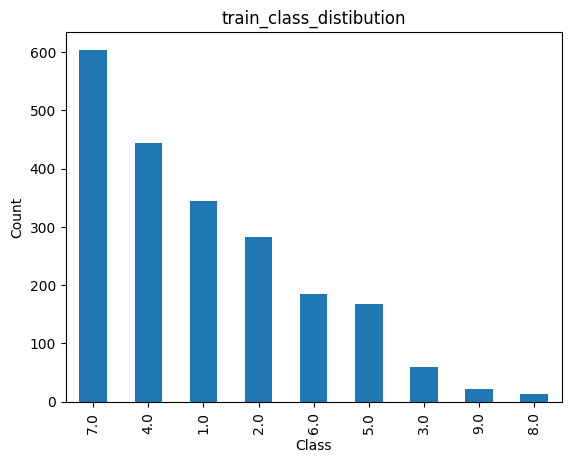

In [12]:
train_class_distibution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("train_class_distibution")

- So we have multi-class classification problem with highly imbalanced data.

Text(0.5, 1.0, 'test_class_distribution')

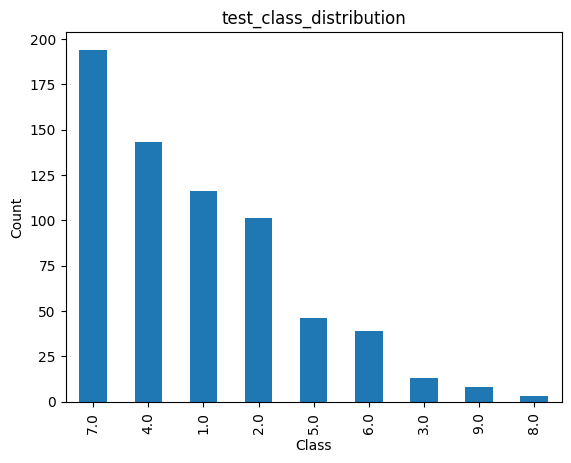

In [13]:
test_class_distribution.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("test_class_distribution")

- Train and test have almost similar distribution on class.

Text(0.5, 1.0, 'validation_class_distribution')

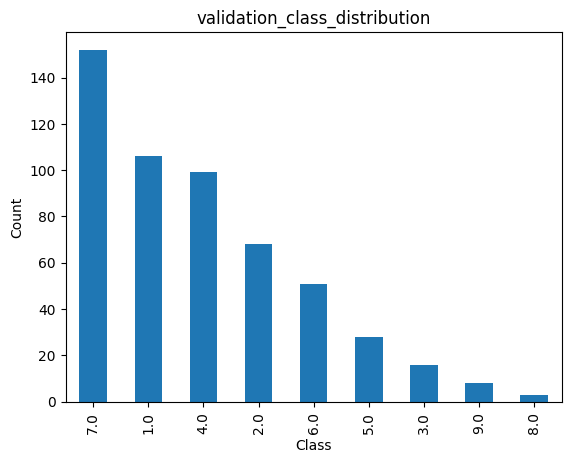

In [14]:
validation_class_distribution.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("validation_class_distribution")

#### Is Geni and Variation feature are stable accross all the Train, Test and Validation data?

In [22]:
test_coverage = len(set(X_test["Gene"]) & set(X_train["Gene"]))
validation_coverage = len(set(X_val["Gene"]) & set(X_train["Gene"]))

print(f"in test data {test_coverage} out of {X_test.shape[0]}")
print(f"in test data {validation_coverage} out of {X_val.shape[0]}")

in test data 134 out of 663
in test data 130 out of 531


In [23]:
test_coverage = len(set(X_test["Variation"]) & set(X_train["Variation"]))
validation_coverage = len(set(X_val["Variation"]) & set(X_train["Variation"]))

print(f"in test data {test_coverage} out of {X_test.shape[0]}")
print(f"in test data {validation_coverage} out of {X_val.shape[0]}")

in test data 134 out of 663
in test data 130 out of 531


In [24]:
unique_words = []
for txt in X_train["Text"]:
    unique_word = list(set(txt.split()))
    unique_words.extend(unique_word) 

print(f"total unique words {len(unique_words)}")

total unique words 3511681


In [25]:
unique_words = pd.Series(unique_words)
unique_words_value_counts = unique_words.value_counts()

In [26]:
# unique_words_value_counts

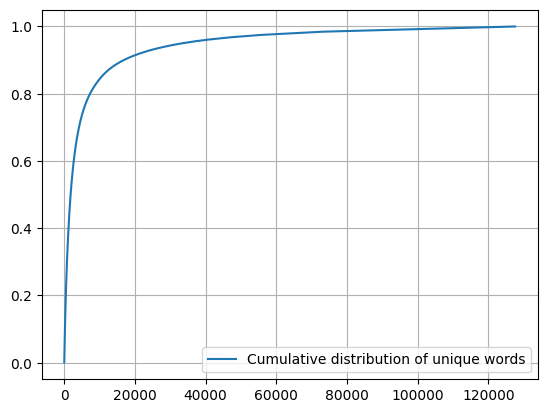

In [33]:
s = sum(unique_words_value_counts.values);
h = unique_words_value_counts.values/s;

c = np.cumsum(h)
plt.plot(c, label="Cumulative distribution of unique words")
plt.grid(axis="both")
plt.legend()
plt.show()

### 3 Prediction Using Random Model:

In [36]:
def plot_confusion_matrics(y_test, y_pred):
    label = [1,2,3,4,5,6,7,8,9]
    C = confusion_matrix(y_test, y_pred)

    A = (((C.T) / C.sum(axis=1)).T)

    B = (C/C.sum(axis=0))

    print("-"*80, "Confusion Matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted Values")
    plt.ylabel("Original Values")
    plt.show()
    
    print("-"*80, "Precision Matrix (Column sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted Values")
    plt.ylabel("Original Values")
    plt.show()
    
    print("-"*80, "Recall Matrix (Column sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=label,yticklabels=label)
    plt.xlabel("Predicted Values")
    plt.ylabel("Original Values")
    plt.show()

In [37]:
import numpy as np
from sklearn.metrics._classification import log_loss

#### 3.1: validation-set-error:

In [38]:
cv_data_len = X_val.shape[0]
cv_predicted_y = np.zeros((cv_data_len,9)) # cv_predicted_y will have 531-col, 9-rows
for i in range(cv_data_len):
    random_probability = np.random.rand(1,9)
    cv_predicted_y[i] = random_probability / random_probability.sum()
print("log-loss on cross validation data using Random Model", log_loss(y_val,cv_predicted_y))

log-loss on cross validation data using Random Model 2.49462903266623


#### 3.2 Test-Set-Error:

In [39]:
test_data_len = X_test.shape[0]

test_predicted_y = np.zeros((test_data_len,9)) # cv_predicted_y will have 531-col, 9-rows
for i in range(test_data_len):
    random_probability = np.random.rand(1,9)
    test_predicted_y[i] = random_probability / random_probability.sum()
print("log-loss on test data using Random Model", log_loss(y_test,test_predicted_y))

log-loss on test data using Random Model 2.4803893555563636


In [40]:
predicted_y = np.argmax(test_predicted_y, axis=1)

-------------------------------------------------------------------------------- Confusion Matrix --------------------


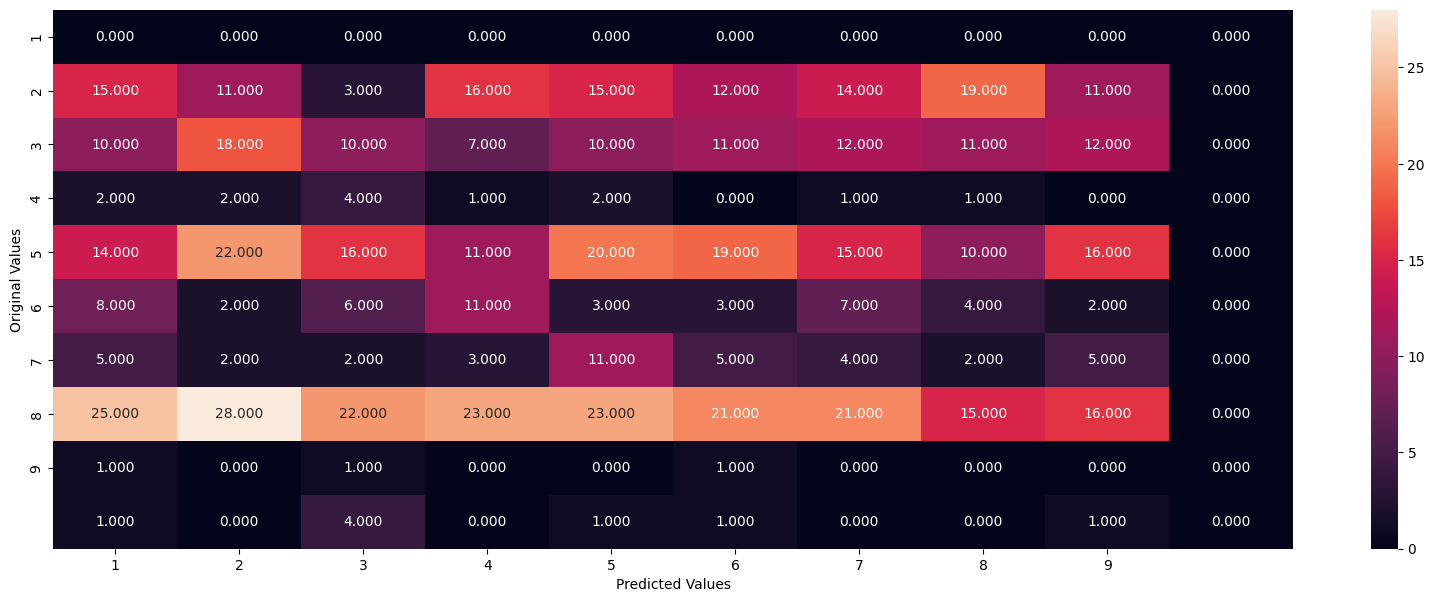

-------------------------------------------------------------------------------- Precision Matrix (Column sum=1) --------------------


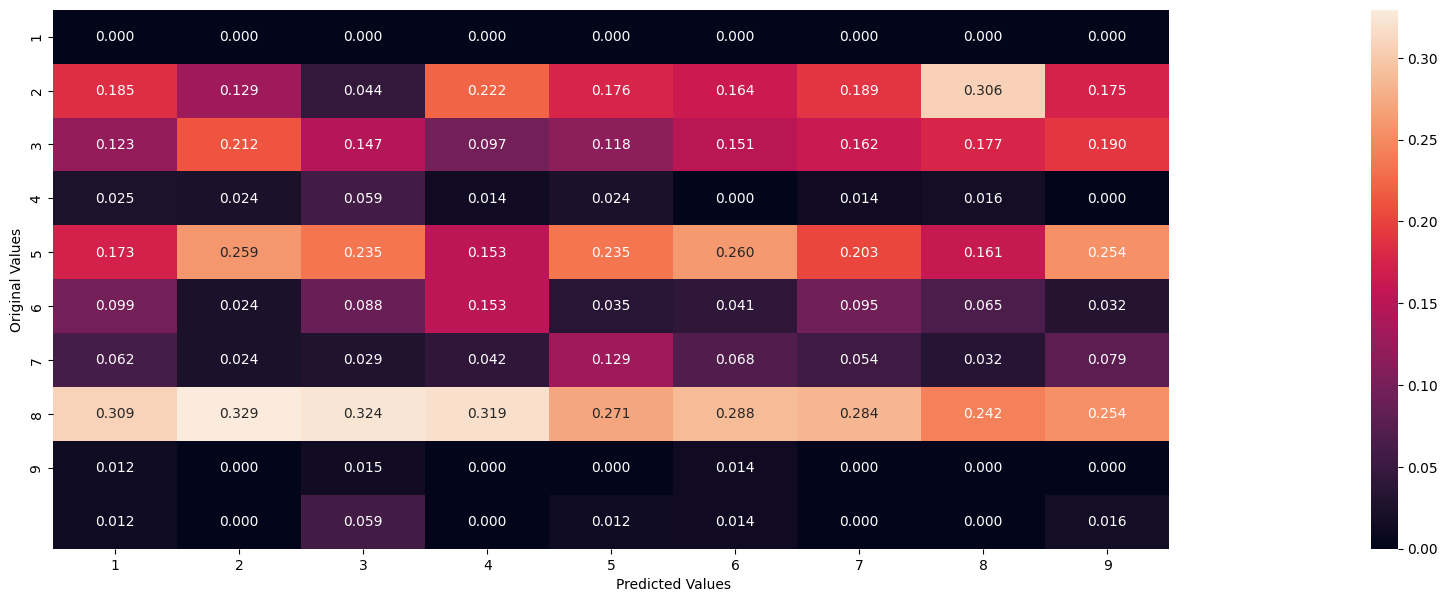

-------------------------------------------------------------------------------- Recall Matrix (Column sum=1) --------------------


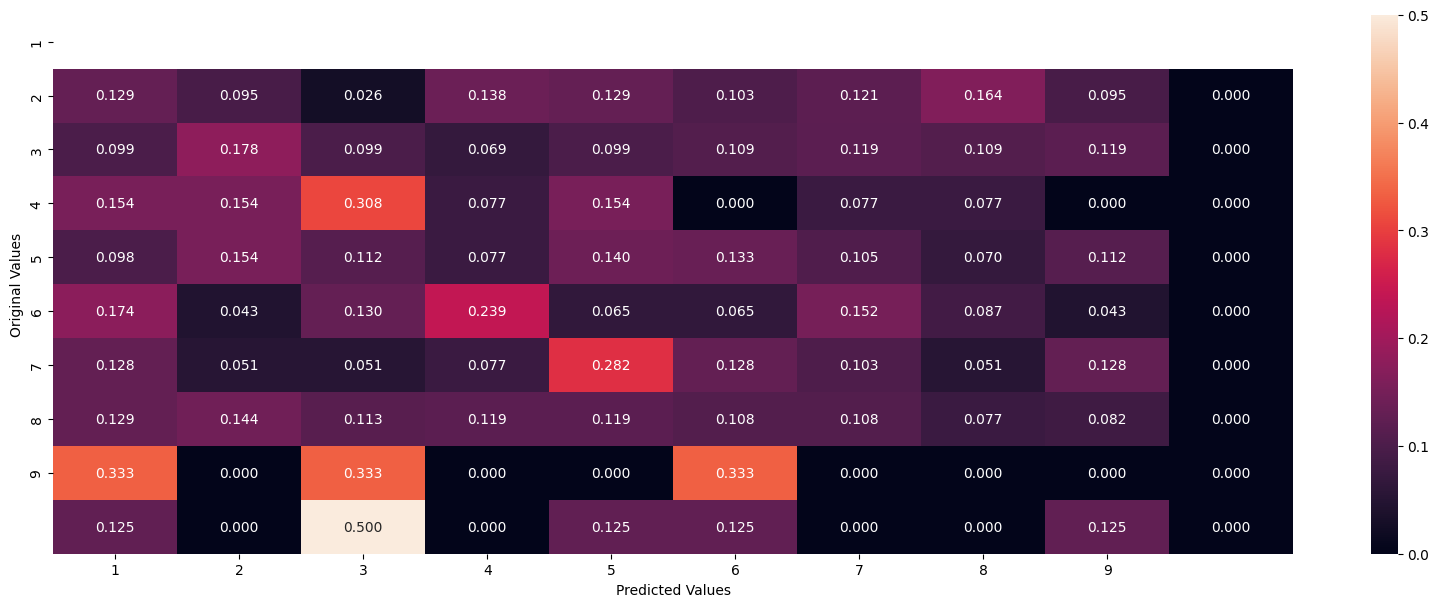

In [41]:
plot_confusion_matrics(y_test, predicted_y)

### 4. Is Geni and variation feature are important for predicting classes: 

#### 4.1: Deciding is Gine model is good at predicting class:

In [42]:
count_vectorizer_gine = CountVectorizer()

gene_x_train_ohe = count_vectorizer_gine.fit_transform(X_train["Gene"])
gene_x_test_ohe = count_vectorizer_gine.transform(X_test["Gene"])
gene_x_val_ohe = count_vectorizer_gine.transform(X_val["Gene"])

In [44]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i,penalty="l2", loss="log_loss",random_state=42)
    clf.fit(gene_x_train_ohe, y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(gene_x_train_ohe, y_train)
    pred_y = sig_clf.predict_proba(gene_x_val_ohe)
    cv_log_error_array.append(log_loss(y_val,pred_y,labels=clf.classes_))

    print(f"for value of alpha {i},The log_loss is: {log_loss(y_val,pred_y)}")

for value of alpha 1e-05,The log_loss is: 1.1620518431467457
for value of alpha 0.0001,The log_loss is: 1.1478092244341342
for value of alpha 0.001,The log_loss is: 1.2216260312700933
for value of alpha 0.01,The log_loss is: 1.380429469320267
for value of alpha 0.1,The log_loss is: 1.4835457511926657
for value of alpha 1,The log_loss is: 1.5264868712216375


#### Training Gene feature on best found alpha value:

In [45]:
best_alpha= np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty="l2", loss="log_loss",random_state=42)
clf.fit(gene_x_train_ohe, y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(gene_x_train_ohe, y_train)


pred_y = sig_clf.predict_proba(gene_x_train_ohe)
print("log loss for train: ", log_loss(y_train,pred_y))
pred_y = sig_clf.predict_proba(gene_x_test_ohe)
print("log loss for test: ", log_loss(y_test,pred_y))
pred_y = sig_clf.predict_proba(gene_x_val_ohe)
print("log loss for validation: ", log_loss(y_val,pred_y))

log loss for train:  1.0019303514246023
log loss for test:  1.1645524460954086
log loss for validation:  1.1478092244341342


#### 4.2: Deciding is Variation feature is good at predicting class:

In [46]:
count_vectorizer_variation = CountVectorizer()

Variation_x_train_ohe = count_vectorizer_variation.fit_transform(X_train["Variation"])
Variation_x_test_ohe = count_vectorizer_variation.transform(X_test["Variation"])
Variation_x_val_ohe = count_vectorizer_variation.transform(X_val["Variation"])

In [47]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i,penalty="l2", loss="log_loss",random_state=42)
    clf.fit(Variation_x_train_ohe, y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(Variation_x_train_ohe, y_train)
    pred_y = sig_clf.predict_proba(Variation_x_val_ohe)
    cv_log_error_array.append(log_loss(y_val,pred_y,labels=clf.classes_))

    print(f"for value of alpha {i},The log_loss is: {log_loss(y_val,pred_y)}")

for value of alpha 1e-05,The log_loss is: 1.1620518431467457
for value of alpha 0.0001,The log_loss is: 1.1478092244341342
for value of alpha 0.001,The log_loss is: 1.2216260312700933
for value of alpha 0.01,The log_loss is: 1.380429469320267
for value of alpha 0.1,The log_loss is: 1.4835457511926657
for value of alpha 1,The log_loss is: 1.5264868712216375


#### Training Variation feature on best found alpha value:

In [48]:
best_alpha= np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty="l2", loss="log_loss",random_state=42)
clf.fit(Variation_x_train_ohe, y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(Variation_x_train_ohe, y_train)


pred_y = sig_clf.predict_proba(Variation_x_train_ohe)
print("log loss for train: ", log_loss(y_train,pred_y))
pred_y = sig_clf.predict_proba(Variation_x_test_ohe)
print("log loss for test: ", log_loss(y_test,pred_y))
pred_y = sig_clf.predict_proba(Variation_x_val_ohe)
print("log loss for validation: ", log_loss(y_val,pred_y))

log loss for train:  1.0019303514246023
log loss for test:  1.1645524460954086
log loss for validation:  1.1478092244341342


In [49]:
conclusion_df = {
    "cv_loss": [1.14,1.16,2.49],
    "test_loss": [1.16,1.14,2.48],
}

pd.DataFrame(conclusion_df, index=["gene", "variation", "random model"])

,cv_loss,test_loss
gene,1.14,1.16
variation,1.16,1.14
random model,2.49,2.48


#### conclusion:
- As we can see both are fetures are important,  so keep both feature for predicting class

#### 4.3: Deciding is test feature is good at predicting class:

- How many unique values are present in train data.
- how are text frequency distributed?
- How to featurize text field?
- Is text feature usefull for predicting y?
- Is the text feature stable across Train,test and validation data?

In [50]:
text_vectorizer = CountVectorizer(min_df=3) # min_df: take those words only which occured atleast 3 times
train_txt_ohe = text_vectorizer.fit_transform(X_train["Text"])
train_text_features = text_vectorizer.get_feature_names_out()

train_text_feature_counts = train_txt_ohe.sum(axis=0).A1

text_feature_dict = dict(zip(list(train_text_features), train_text_feature_counts))
print(f"total_number of unique words in train data: {len(train_text_features)}")

total_number of unique words in train data: 54516


In [51]:
# Normalizing every feature
train_txt_ohe = normalize(train_txt_ohe)
test_text_ohe = normalize(text_vectorizer.transform(X_test["Text"]))
val_text_ohe = normalize(text_vectorizer.transform(X_val["Text"]))

In [ ]:
alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha=i,penalty="l2", loss="log_loss",random_state=42)
    clf.fit(train_txt_ohe, y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(train_txt_ohe, y_train)
    pred_y = sig_clf.predict_proba(val_text_ohe)
    cv_log_error_array.append(log_loss(y_val,pred_y,labels=clf.classes_))

    print(f"for value of alpha {i},The log_loss is: {log_loss(y_val,pred_y)}")

#### Training text feature on best found alpha value:

In [52]:
best_alpha= np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty="l2", loss="log_loss",random_state=42)
clf.fit(train_txt_ohe, y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_txt_ohe, y_train)


pred_y = sig_clf.predict_proba(train_txt_ohe)
print("log loss for train: ", log_loss(y_train,pred_y))
pred_y = sig_clf.predict_proba(test_text_ohe)
print("log loss for test: ", log_loss(y_test,pred_y))
pred_y = sig_clf.predict_proba(val_text_ohe)
print("log loss for validation: ", log_loss(y_val,pred_y))

log loss for train:  0.9759799686631719
log loss for test:  1.3223355375271908
log loss for validation:  1.34896768400456


In [53]:
conclusion_df = {
    "cv_loss": [1.14,1.16,1.34,2.49],
    "test_loss": [1.16,1.14,1.32,2.48],
}

pd.DataFrame(conclusion_df, index=["gene", "variation", "text","random model"])

,cv_loss,test_loss
gene,1.14,1.16
variation,1.16,1.14
text,1.34,1.32
random model,2.49,2.48


In [54]:
def get_intersaction_text(df):
    df_text_vec = CountVectorizer(max_df=3)
    df_text_fea = df_text_vec.fit_transform(df["Text"])
    df_text_feature =df_text_vec.get_feature_names_out()
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_feature), df_text_fea_counts))
    len1 = len(set(df_text_feature))
    len2 = len(set(train_text_features) & set(df_text_feature))
    return len1,len2

In [55]:
len1, len2 = get_intersaction_text(X_test)
print(np.round((len1/len2*100),3), "% of word of test data appeared in training data.")
len1, len2 = get_intersaction_text(X_val)
print(np.round((len2/len1)*100,3), "% of word of validation data appeared in training data.")

234.184 % of word of test data appeared in training data.
47.453 % of word of validation data appeared in training data.


## 5. Machine Learning Models:

In [56]:
y_train = y_train.astype("int")
y_test = y_test.astype("int")
y_val = y_val.astype("int")

In [57]:
def predict_and_plot_confusion_matrix(train_x, train_y, x_test, y_test, clf):
    clf.fit(train_x,train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    y_pred = sig_clf.predict(x_test)


    print(f"Log_loss {log_loss(y_test, sig_clf.predict_proba(x_test))}")
    print(f"number of missclassified points: {np.count_nonzero((y_pred-x_test))}")

    plot_confusion_matrics(y_test,y_pred)

In [58]:
def report_log_loss(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf_probs = sig_clf.predict_proba(X_test)
    return log_loss(y_test, sig_clf_probs, eps=1e-15)

### prepairing train-test-validation data:

### 1. CountVectorizer:

In [59]:
train_df = hstack((gene_x_train_ohe,Variation_x_train_ohe))
train_df_ohe = hstack((train_df, train_txt_ohe))

In [60]:
test_df = hstack((gene_x_test_ohe,Variation_x_test_ohe))
test_df_ohe = hstack((test_df, test_text_ohe))

In [61]:
validation_df = hstack((gene_x_val_ohe,Variation_x_val_ohe))
validation_df_ohe = hstack((validation_df, val_text_ohe))

In [62]:
print("One hot encoding features :")

print("(Numner of data points * Number of features) in train data = ", train_df_ohe.shape)
print("(Numner of data points * Number of features) in test data = ", test_df_ohe.shape)
print("(Numner of data points * Number of features) in validation data = ", validation_df_ohe.shape)

One hot encoding features :
(Numner of data points * Number of features) in train data =  (2121, 54968)
(Numner of data points * Number of features) in test data =  (663, 54968)
(Numner of data points * Number of features) in validation data =  (531, 54968)


### 2. ResponseCoding :

In [63]:
from response_encoding import CategoricalMeanValueReplacement,TextMeanValueReplacement
vectorizer = CountVectorizer()

In [64]:
gene_cmvr = CategoricalMeanValueReplacement()
variation_cmvr = CategoricalMeanValueReplacement()
tmvr = TextMeanValueReplacement(X_train, "Text", "Class", 1, 9, vectorizer)

In [65]:
gene_cmvr.fit(1,X_train,"Gene","Class")
variation_cmvr.fit(1,X_train,"Variation","Class")
tmvr.fit()

TextMeanValueReplacement(alpha=1, feature='Text', n_class=9, target='Class',
                         vectorizer=CountVectorizer(),
                         xtrain=        ID    Gene Variation  \
2000  2005  MAP2K1    MAP2K1   
2532  2537   BRCA1     BRCA1   
101    102    MSH6      MSH6   
2468  2473   BRCA1     BRCA1   
1097  1098    BAP1      BAP1   
...    ...     ...       ...   
1204  1206  PIK3CA    PIK3CA   
2905  2911  NFE2L2    NFE2L2   
517    518    TP53      TP53   
2746  2751    BRAF      BRAF   
1529  1533     ALK       ALK   

                                                   Text  Class  
2000  histiocytic neoplasms clonal hema...
2468  mutations brca1 brca2 account majority heredit...    6.0  
1097  wnt signaling pathway essential development or...    1.0  
...                                                 ...    ...  
1204  pik3ca gene coding catalytic subunit p110 clas...    7.0  
2905  carcinomas thyroid comprise heterogeneous grou...    7.0  
517   inheritance germ line mutant alleles brca1 brc...    4.0  
2746  braf mutations found subset non small cell lun...    2.0  
1529  thyroid cancer common endocrine malignancy enc...    7.0  

[2121 rows x 5 columns])

In [66]:
train_gene_response_encoding = gene_cmvr.transform(X_train)
test_gene_response_encoding = gene_cmvr.transform(X_test)
validation_gene_response_encoding = gene_cmvr.transform(X_val)

In [67]:
train_variation_response_encoding = variation_cmvr.transform(X_train)
test_variation_response_encoding = variation_cmvr.transform(X_test)
validation_variation_response_encoding = variation_cmvr.transform(X_val)

In [68]:
train_text_response_encoding = tmvr.transform(X_train,"Class")
test_text_response_encoding = tmvr.transform(X_test,"Class")
validation_text_response_encoding = tmvr.transform(X_val,"Class")

In [69]:
train_df_re = np.hstack((train_gene_response_encoding,train_variation_response_encoding))
train_df_re = np.hstack((train_df_re,train_text_response_encoding))

In [70]:
test_df_re = np.hstack((test_gene_response_encoding,test_variation_response_encoding))
test_df_re = np.hstack((test_df_re,test_text_response_encoding))

In [71]:
validation_df_re = np.hstack((validation_gene_response_encoding,validation_variation_response_encoding))
validation_df_re = np.hstack((validation_df_re,validation_text_response_encoding))

In [72]:
print("One hot encoding features :")

print("(Numner of data points * Number of features) in train data = ", train_df_re.shape)
print("(Numner of data points * Number of features) in test data = ", test_df_re.shape)
print("(Numner of data points * Number of features) in validation data = ", validation_df_re.shape)

One hot encoding features :
(Numner of data points * Number of features) in train data =  (2121, 27)
(Numner of data points * Number of features) in test data =  (663, 27)
(Numner of data points * Number of features) in validation data =  (531, 27)


#### 5.1 Naive Bayes:

for alpha 1e-05
531 531
log loss : 1.4193586765634074
for alpha 0.0001
531 531
log loss : 1.4196696198281284
for alpha 0.001
531 531
log loss : 1.4122457002500848
for alpha 0.1
531 531
log loss : 1.4212814965813596
for alpha 1
531 531
log loss : 1.4907428772704414
for alpha 10
531 531
log loss : 1.4614230625346547
for alpha 100
531 531
log loss : 1.4758713274572692
for alpha 1000
531 531
log loss : 1.4815073581486293
for best alpha  0.001 The train log loss is:  1.125824353018728
for best alpha  0.001 The validation log loss is:  1.4122457002500848
for best alpha  0.001 The test log loss is:  1.4002330878690488


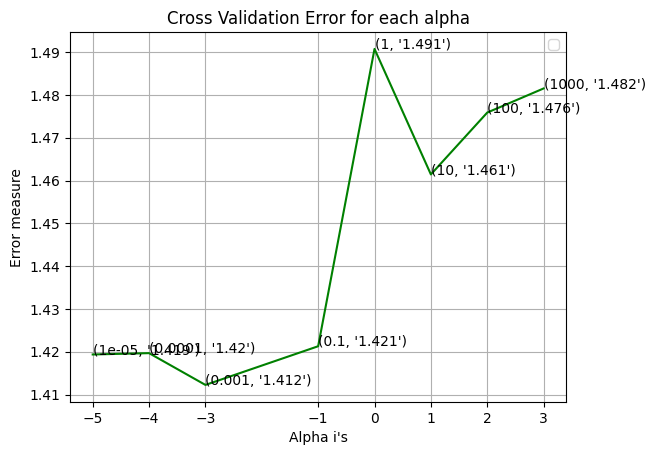

In [73]:
alpha = [0.00001,0.0001,0.001,0.1,1,10,100,1000]
cv_log_error_array = []
for i in alpha:
    print(f"for alpha {i}")
    clf = MultinomialNB(alpha=i)
    clf.fit(train_df_ohe, y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(train_df_ohe, y_train)
    sig_clf_prob = sig_clf.predict_proba(validation_df_ohe)
    print(len(y_val), len(sig_clf_prob))
    cv_log_error_array.append(log_loss(y_val, sig_clf_prob, labels=clf.classes_))
    print("log loss :", log_loss(y_val, sig_clf_prob))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c="g")
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_df_ohe, y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_df_ohe, y_train)


sig_clf_prob = sig_clf.predict_proba(train_df_ohe)
print("for best alpha ", alpha[best_alpha], "The train log loss is: ",log_loss(y_train, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(validation_df_ohe)
print("for best alpha ", alpha[best_alpha], "The validation log loss is: ",log_loss(y_val, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(test_df_ohe)
print("for best alpha ", alpha[best_alpha], "The test log loss is: ",log_loss(y_test, sig_clf_prob, labels=clf.classes_))

In [ ]:
# from confusion matrix: of all the points get predicted as class-1 among them 47% are actually belongs to class-1
# from precision matrix: of all the points get predicted as class-1 among them 30% are actually belongs to class-4
# from recall matrix: of all the points belongs class-6 among them 13% are predicted as class-1, 39% predicted as class-6 it self

-------------------------------------------------------------------------------- Confusion Matrix --------------------


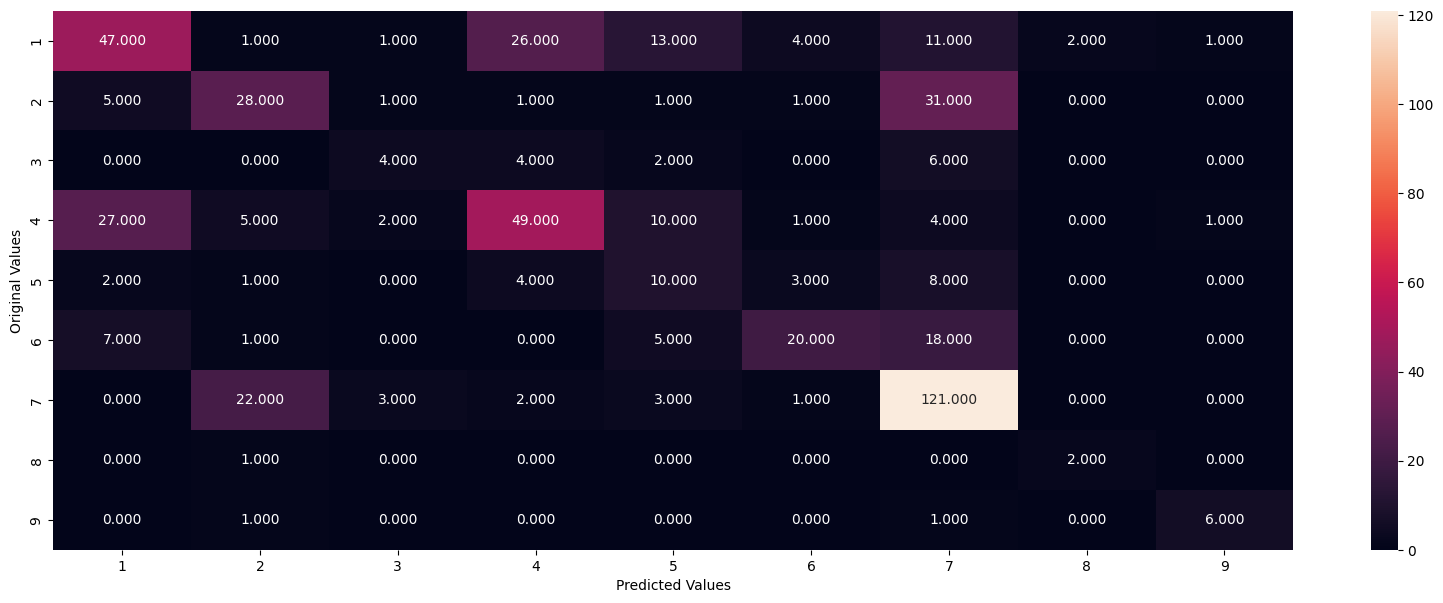

-------------------------------------------------------------------------------- Precision Matrix (Column sum=1) --------------------


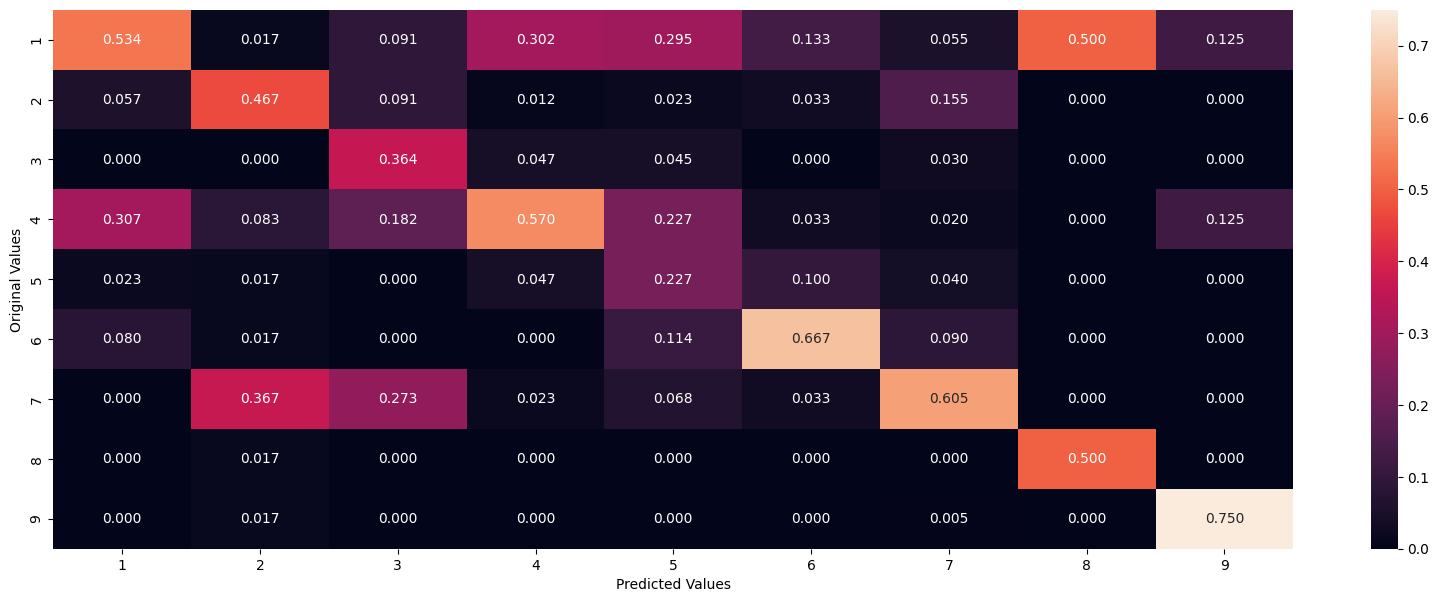

-------------------------------------------------------------------------------- Recall Matrix (Column sum=1) --------------------


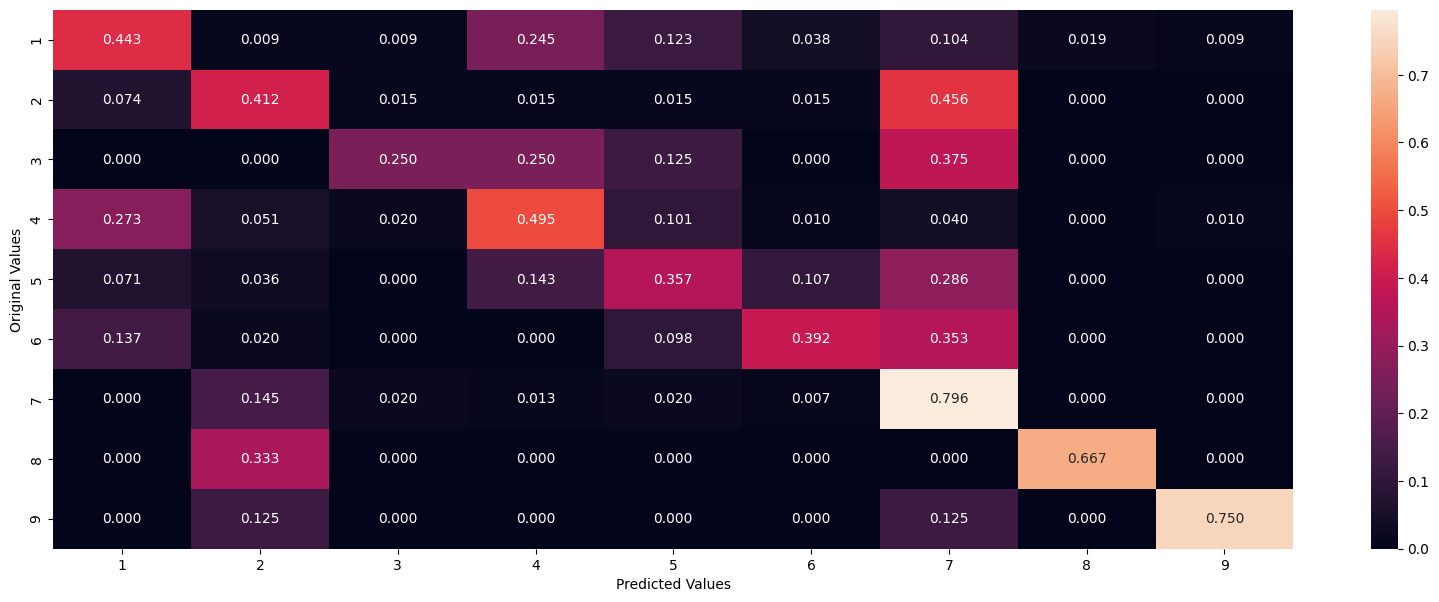

In [74]:
sig_clf_prob = sig_clf.predict(validation_df_ohe)
plot_confusion_matrics(y_val,sig_clf_prob)

#### 5.2 LogisticRegression + CalibratedClassifierCV

for alpha 1e-05
log loss : 1.3911276271100492
for alpha 0.0001
log loss : 1.3900793315962927
for alpha 0.001
log loss : 1.383256633054609
for alpha 0.1
log loss : 1.229151869697991
for alpha 1
log loss : 1.1790544789124293
for alpha 10
log loss : 1.2153246169533516
for alpha 100
log loss : 1.2749192304121792
for alpha 1000
log loss : 1.2612232078044454
for best alpha  1 The train log loss is:  0.9663099363114661
for best alpha  1 The validation log loss is:  1.1933739903528915
for best alpha  1 The test log loss is:  1.1852576314858125


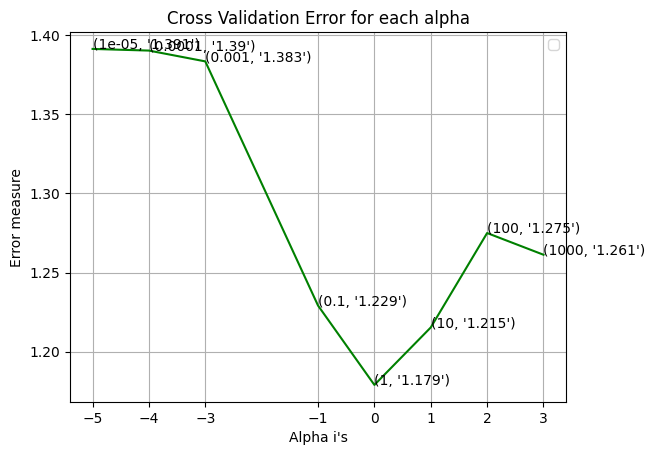

In [91]:
alpha = [0.00001,0.0001,0.001,0.1,1,10,100,1000]
cv_log_error_array = []
for i in alpha:
    print(f"for alpha {i}")
    clf = LogisticRegression(C=i, class_weight="balanced",multi_class="ovr", penalty="l2")
    clf.fit(train_df_ohe, y_train)
    sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(train_df_ohe, y_train)
    sig_clf_prob = sig_clf.predict_proba(validation_df_ohe)
    # print(len(y_val), len(sig_clf_prob))
    cv_log_error_array.append(log_loss(y_val, sig_clf_prob, labels=clf.classes_))
    print("log loss :", log_loss(y_val, sig_clf_prob))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array, c="g")
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]), cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.legend()


best_alpha = np.argmin(cv_log_error_array)
clf = LogisticRegression(C=alpha[best_alpha])
clf.fit(train_df_ohe, y_train)
sig_clf = CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(train_df_ohe, y_train)


sig_clf_prob = sig_clf.predict_proba(train_df_ohe)
print("for best alpha ", alpha[best_alpha], "The train log loss is: ",log_loss(y_train, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(validation_df_ohe)
print("for best alpha ", alpha[best_alpha], "The validation log loss is: ",log_loss(y_val, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(test_df_ohe)
print("for best alpha ", alpha[best_alpha], "The test log loss is: ",log_loss(y_test, sig_clf_prob, labels=clf.classes_))

### 5.3 Decision Tree:(re)

In [92]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,10,12],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,5]
}

In [93]:
# performing grid search to find best hyperparameters
dt_clf = tree.DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt_clf,cv=5,param_grid=param_grid,n_jobs=-1,scoring='neg_log_loss')
grid_search_dt.fit(train_df_re,y_train)

# training decision tree on best find parameters
dt_clf = tree.DecisionTreeClassifier(**grid_search_dt.best_params_)
dt_clf.fit(np.array(train_df_re), y_train)
sig_clf = CalibratedClassifierCV(dt_clf,method="sigmoid")
sig_clf.fit(np.array(train_df_re), y_train)


sig_clf_prob = sig_clf.predict_proba(np.array(train_df_re))
print("The train log loss is: ",log_loss(y_train, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(np.array(validation_df_re))
print("The validation log loss is: ",log_loss(y_val, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(np.array(test_df_re))
print("The test log loss is: ",log_loss(y_test, sig_clf_prob, labels=clf.classes_))

The train log loss is:  0.021294985973716946
The validation log loss is:  0.25619717026821165
The test log loss is:  0.24492244721570305


-------------------------------------------------------------------------------- Confusion Matrix --------------------


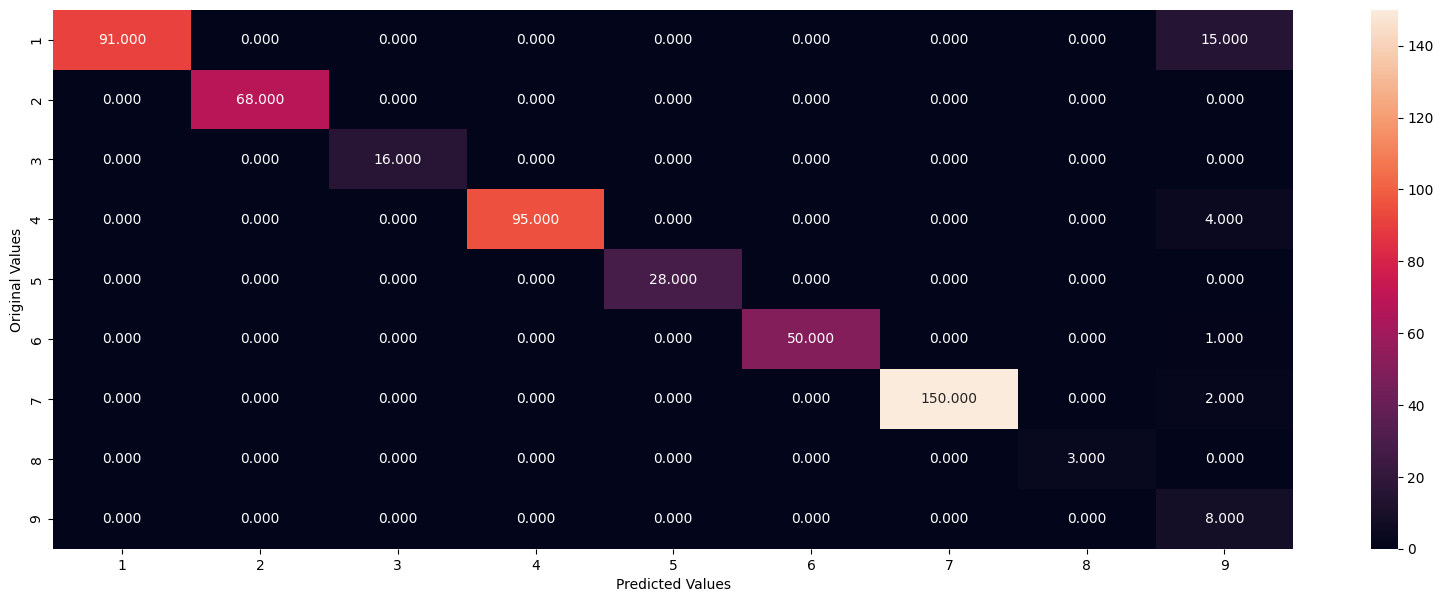

-------------------------------------------------------------------------------- Precision Matrix (Column sum=1) --------------------


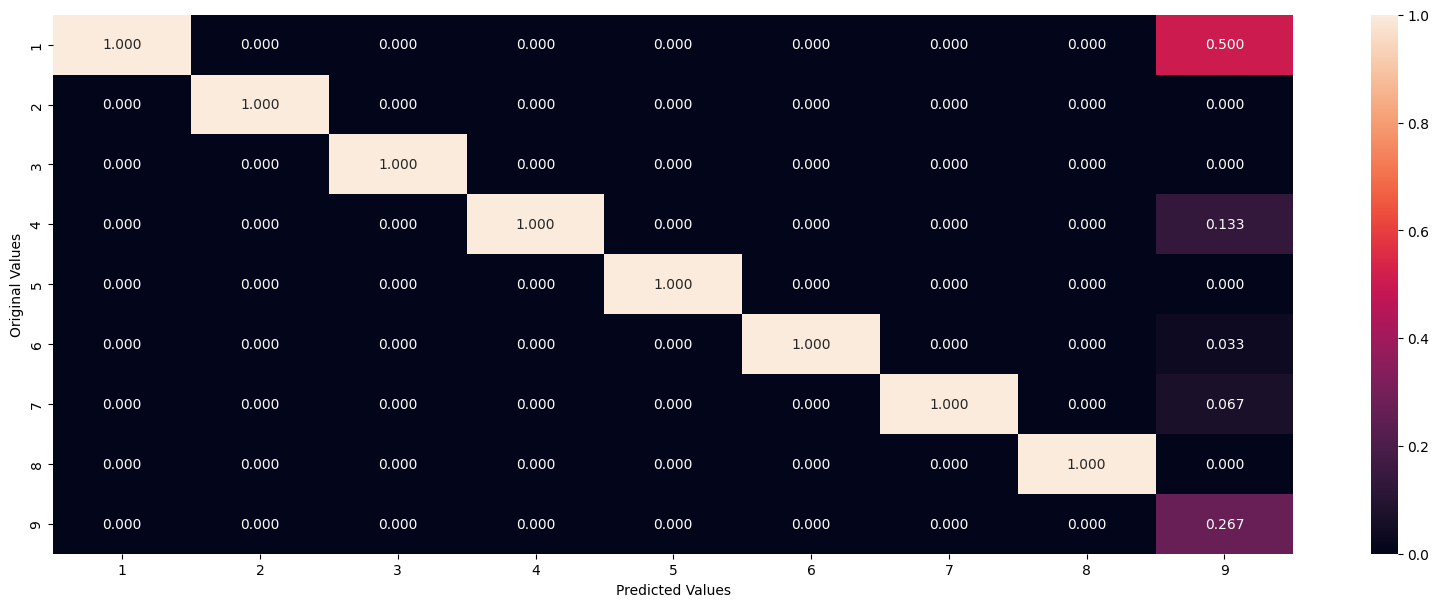

-------------------------------------------------------------------------------- Recall Matrix (Column sum=1) --------------------


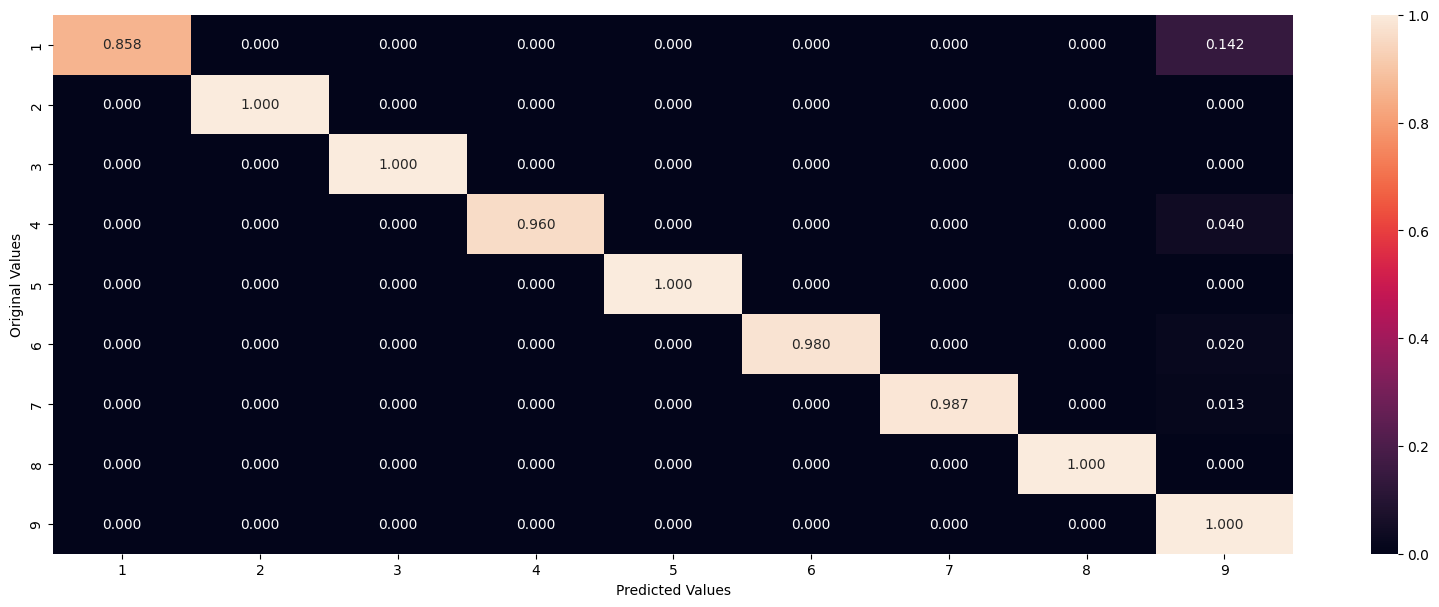

In [94]:
sig_clf_prob = sig_clf.predict(validation_df_re)
plot_confusion_matrics(y_val,sig_clf_prob)

-------------------------------------------------------------------------------- Confusion Matrix --------------------


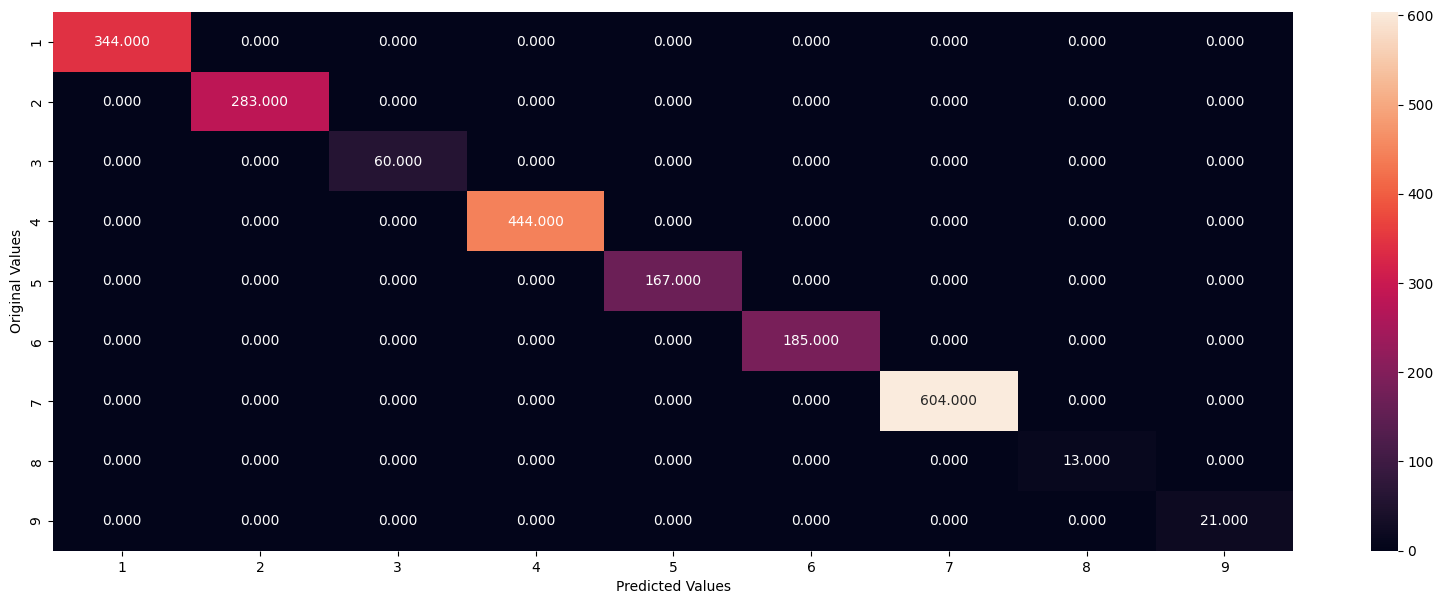

-------------------------------------------------------------------------------- Precision Matrix (Column sum=1) --------------------


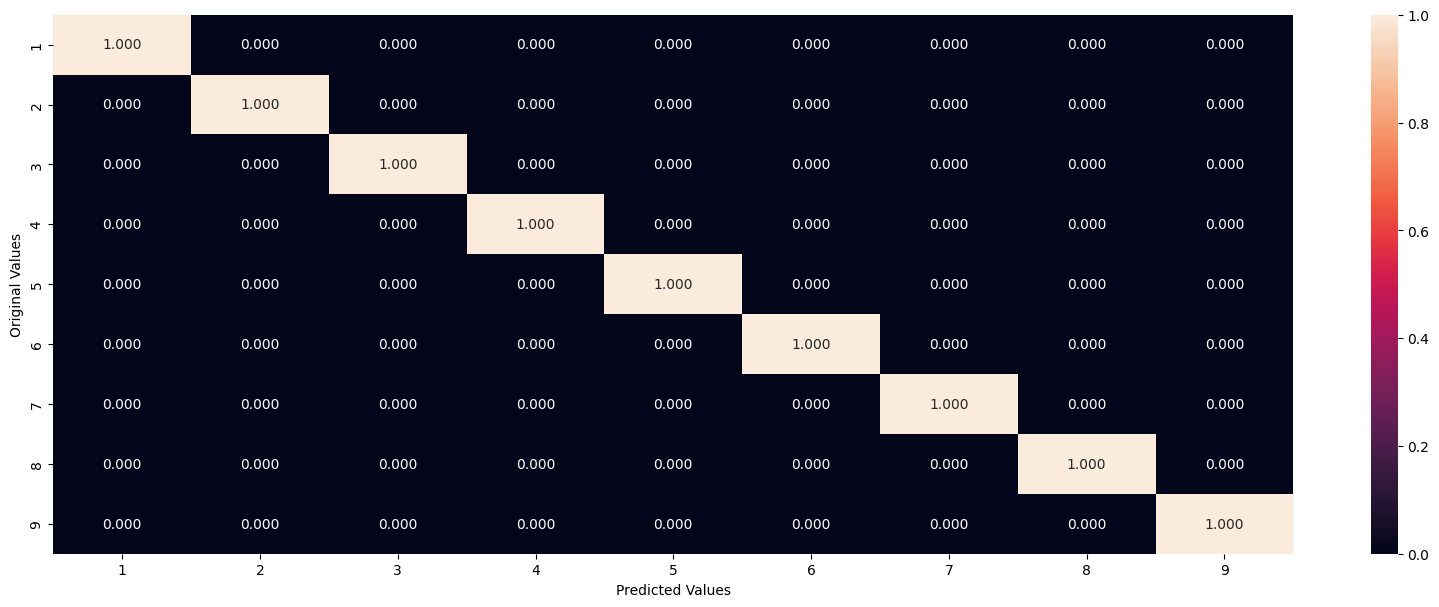

-------------------------------------------------------------------------------- Recall Matrix (Column sum=1) --------------------


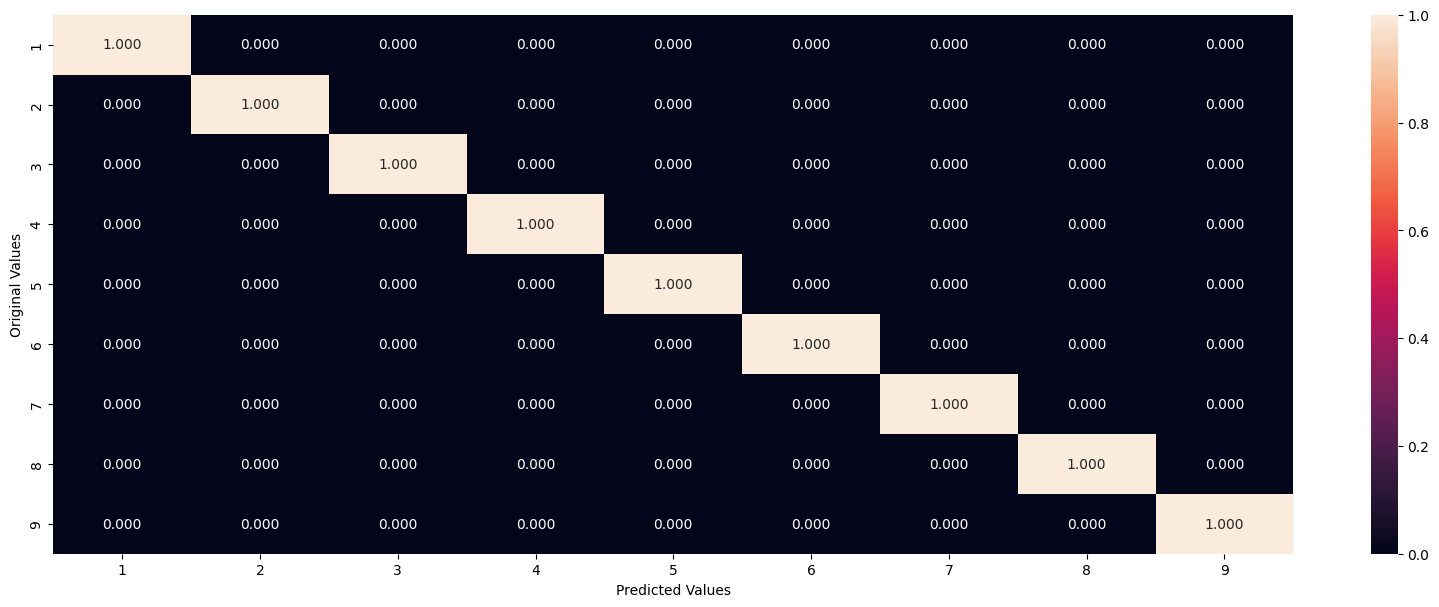

In [78]:
sig_clf_prob = sig_clf.predict(train_df_re)
plot_confusion_matrics(y_train,sig_clf_prob)

-------------------------------------------------------------------------------- Confusion Matrix --------------------


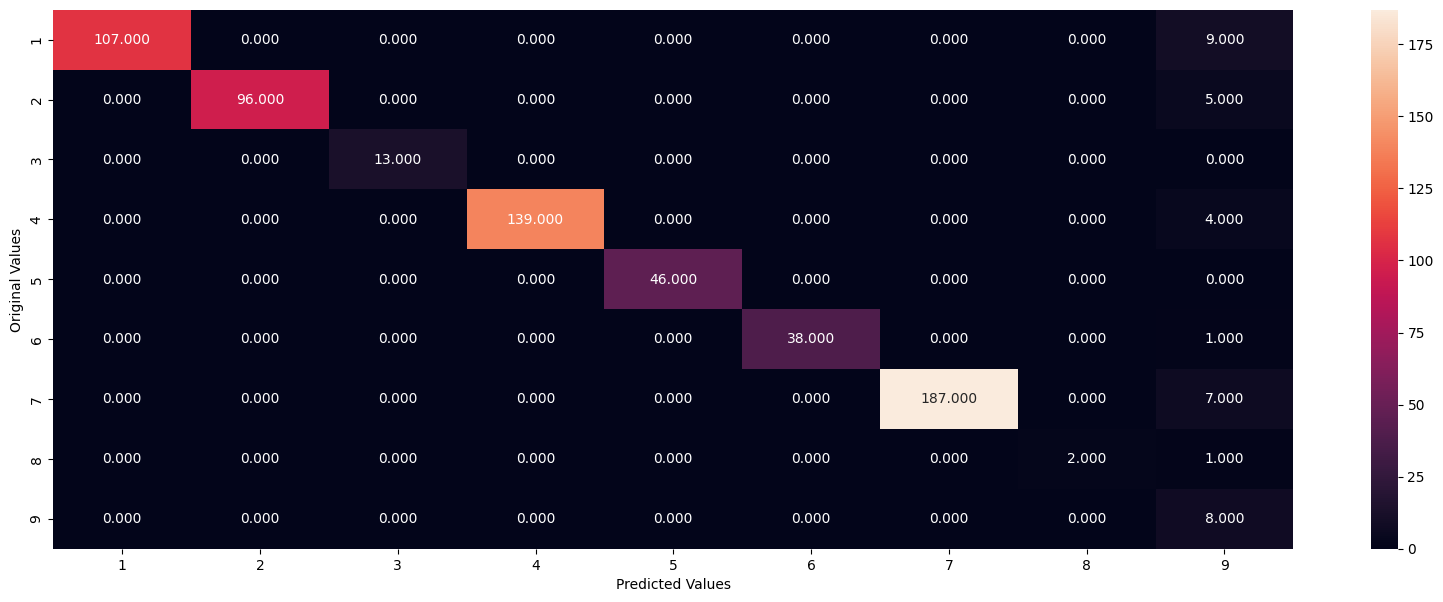

-------------------------------------------------------------------------------- Precision Matrix (Column sum=1) --------------------


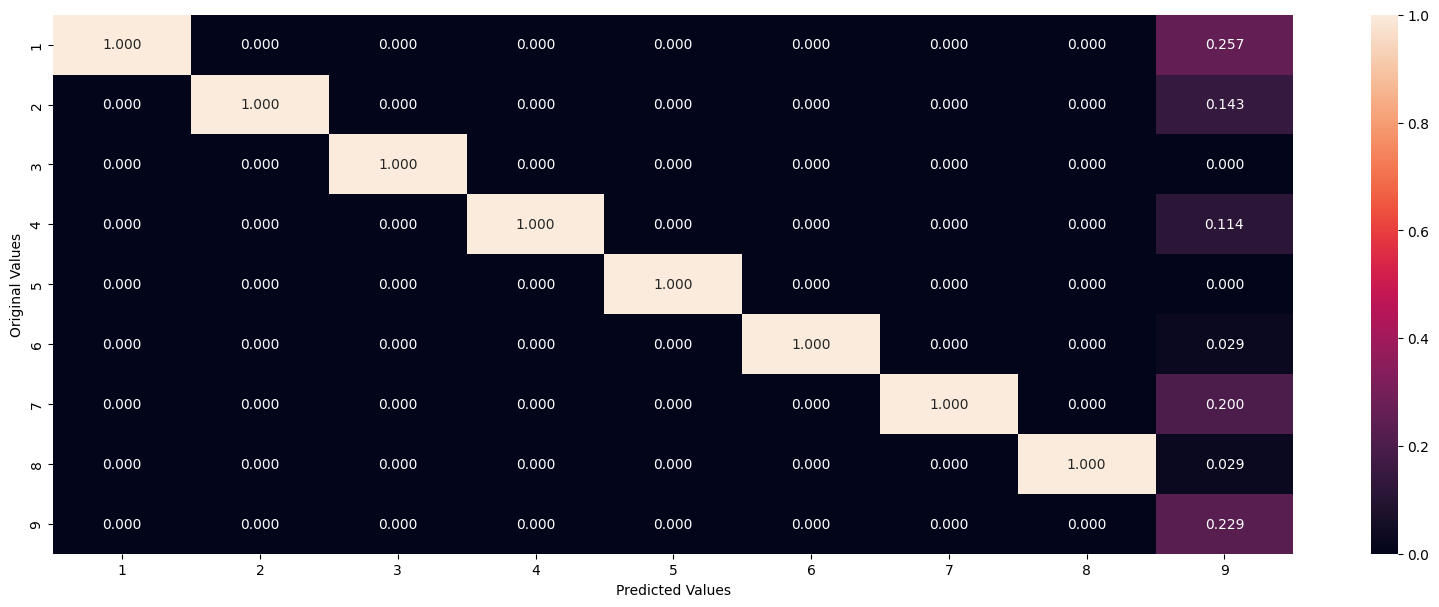

-------------------------------------------------------------------------------- Recall Matrix (Column sum=1) --------------------


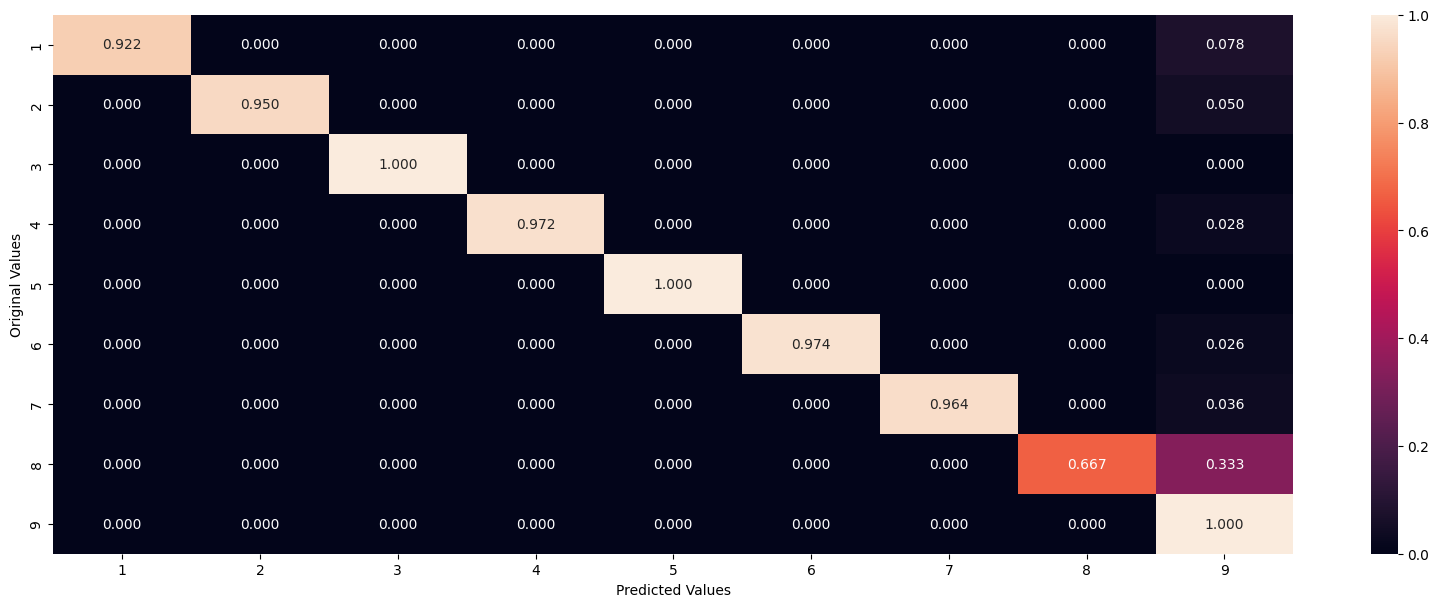

In [95]:
sig_clf_prob = sig_clf.predict(test_df_re)
plot_confusion_matrics(y_test,sig_clf_prob)

#### 5.4. Ensamble Model: Random Forest Classifier:

In [96]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,10,12],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,5]
}

In [97]:
rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_clf,param_grid=param_grid,cv=5,scoring="neg_log_loss",n_jobs=-1,verbose=1)
grid_search_rf.fit(train_df_re,y_train)

dt_clf = RandomForestClassifier(**grid_search_rf.best_params_)
dt_clf.fit(np.array(train_df_re), y_train)
sig_clf = CalibratedClassifierCV(dt_clf,method="sigmoid")
sig_clf.fit(np.array(train_df_re), y_train)

sig_clf_prob = sig_clf.predict_proba(np.array(train_df_re))
print("The train log loss is: ",log_loss(y_train, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(np.array(validation_df_re))
print("The validation log loss is: ",log_loss(y_val, sig_clf_prob, labels=clf.classes_))

sig_clf_prob = sig_clf.predict_proba(np.array(test_df_re))
print("The test log loss is: ",log_loss(y_test, sig_clf_prob, labels=clf.classes_))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
The train log loss is:  0.021249665061189547
The validation log loss is:  0.14031191205166882
The test log loss is:  0.1380312228050199


-------------------------------------------------------------------------------- Confusion Matrix --------------------


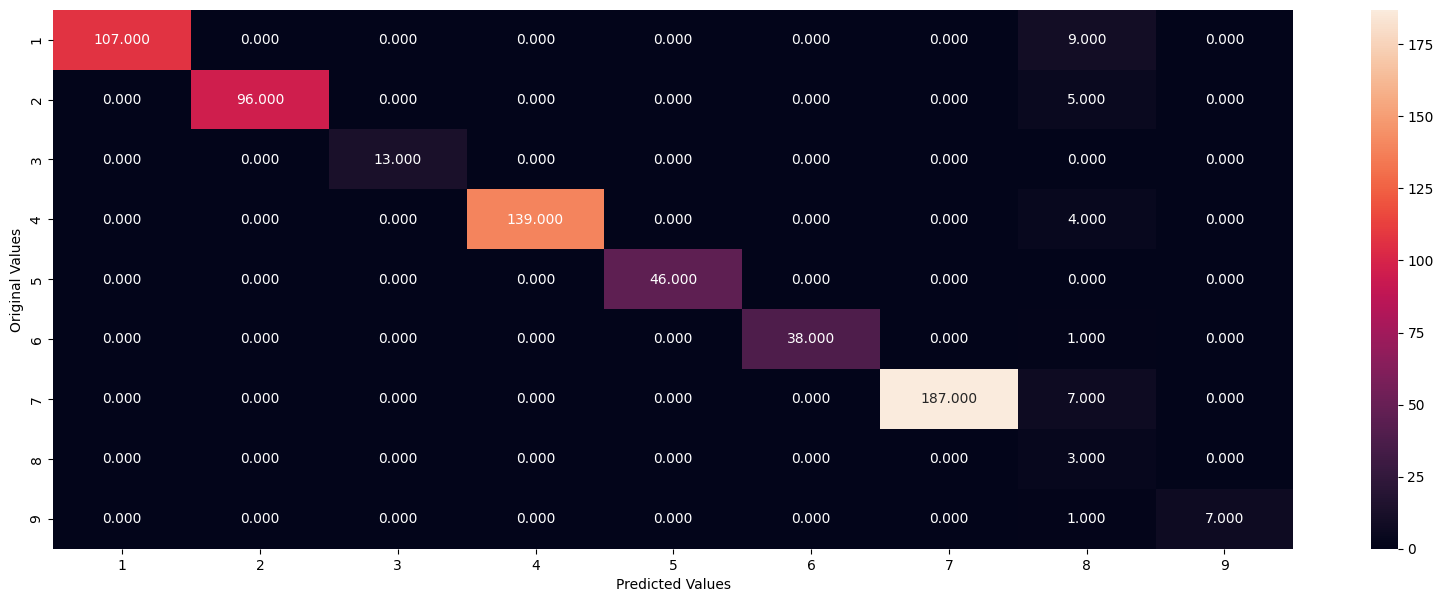

-------------------------------------------------------------------------------- Precision Matrix (Column sum=1) --------------------


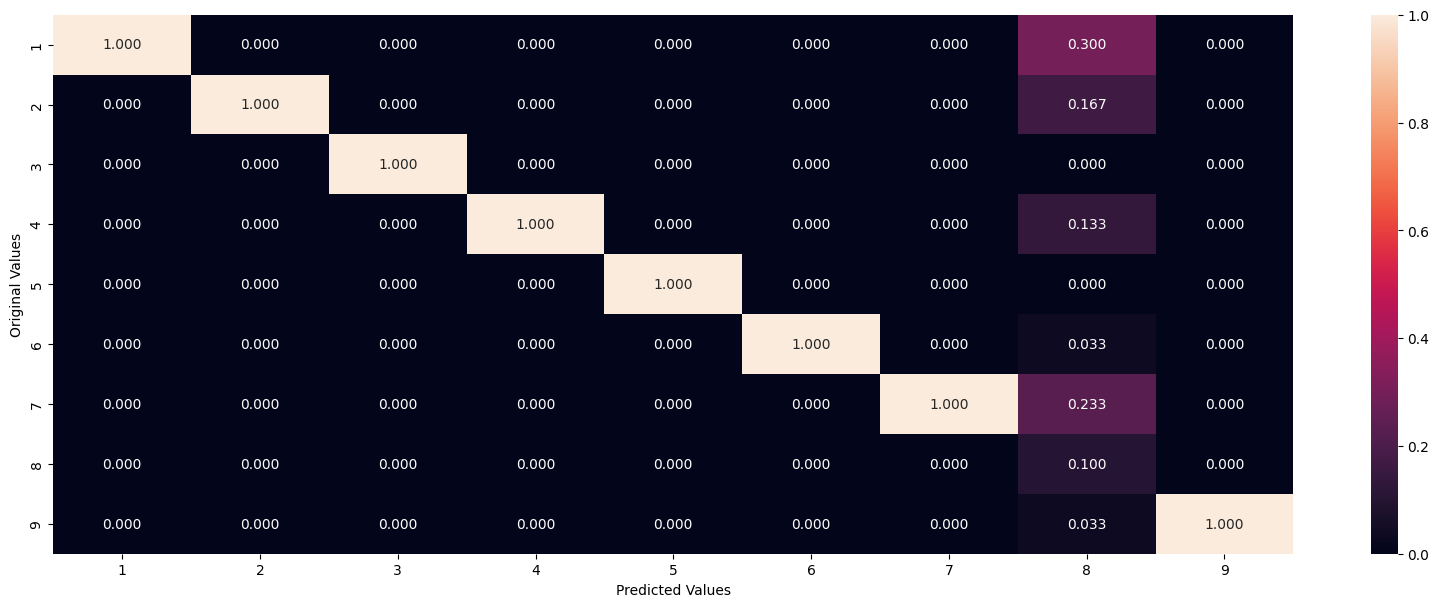

-------------------------------------------------------------------------------- Recall Matrix (Column sum=1) --------------------


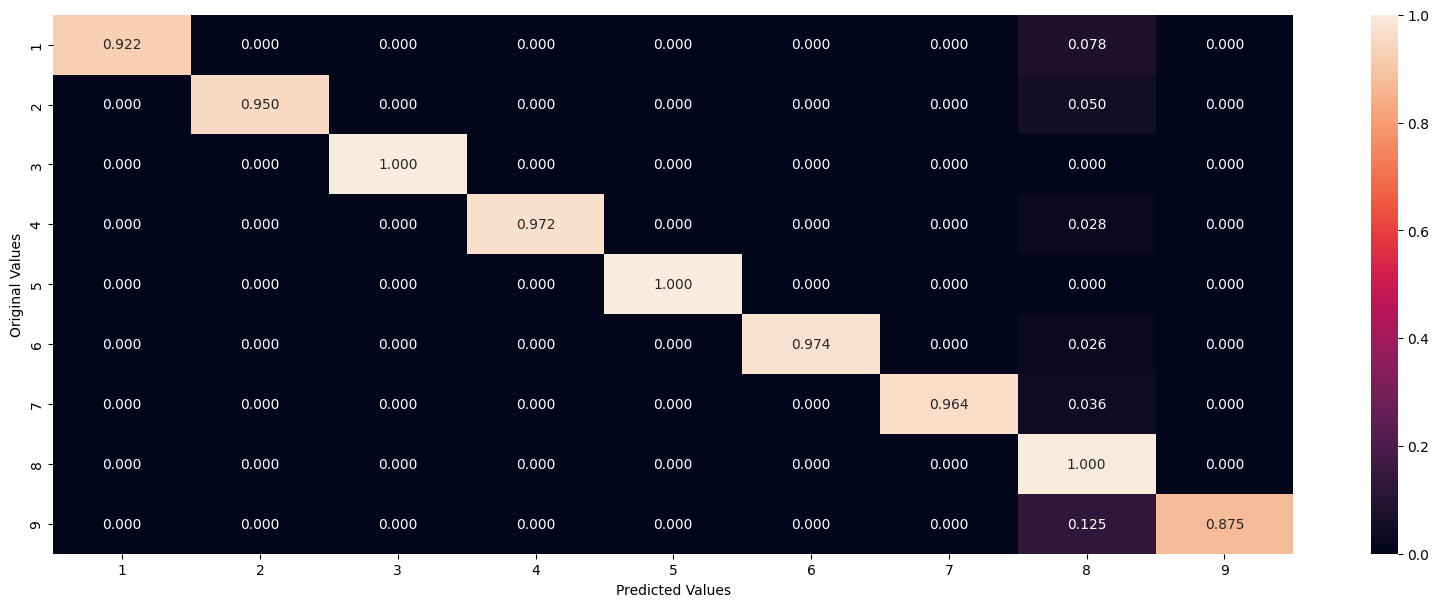

In [98]:
sig_clf_prob = sig_clf.predict(test_df_re)
plot_confusion_matrics(y_test,sig_clf_prob)

In [ ]:
# https://residentmario.github.io/pytorch-training-performance-guide/gradient-checkpoints.html

- Q1. what is num_embeddings?
- Q2. what is squeeze?
- Q3. what is text_embedded.mean(dim=1)?
- Q4. what is hidden_dim in LSTM as well as sequentiial?
- Q5 why doing this lstm_out[:, -1, :]?